# Sensitivity analysis on WOFOST
*This Notebook is adopted from Steven Hoek and Allard de Wit, Wageningen Environmental Sciences* 

Sensitivity analysis is the study of how the uncertainty in the output of a mathematical model or system can be apportioned to different sources of uncertainty in its inputs. The sensitivity of each input is often represented by a numeric value, called the sensitivity index.

A limitation of this notebook is that is only applies for the scalar parameters in WOFOST. WOFOST also has a number of tabular parameters which are defined as a function of development stage or temperature. The sensitivity of these parameters cannot be properly analyzed with the approach used in this notebook.

Below the WOFOST model is run for a sugar beet crop in the Netherlands and then sensitivity analysis is applied. The target variable for sensitivity is the total weight of the storage organs (TWSO) which represents the crop yield. However, other variables could be choosen as well such as total crop biomass or maximum leaf area index.

**Dependencies**
This notebook require the following package to be installed:
- [PCSE](https://pcse.readthedocs.io/en/stable/) and its dependencies (numpy, pandas, PyYAML, SQLAlchemy,...)
- [SAlib](https://salib.readthedocs.io/en/latest/)
- [IPython](http://ipython.org/)

In [1]:
import sys, os.path

import yaml
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", 250)

import pcse
from pcse.models import Wofost71_PP
from pcse.base import ParameterProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.fileinput import YAMLCropDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
from progressbar import printProgressBar
from pcse.fileinput import CABOFileReader
from pcse.engine import Engine

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


This notebook was built with:
python version: 3.8.5 (default, Sep  8 2020, 09:56:35) 
[Clang 9.0.0 (clang-900.0.39.2)] 
PCSE version: 5.4.2


## WOFOST parameters
The table below gives an overview of all the important scalar WOFOST parameters.

In [2]:
df = pd.read_excel("ScalarParametersOfWofost-All.xlsx")
display(df)

,Name,Typical Value,Category,Description,Unit
0,CFET,1.0000,Water use,correction factor for evapotranspiration,-
1,CVL,0.7200,Conversion of assimilates into biomass,efficiency conversion of assimilates into leaf dry matter,kg / kg
2,CVO,0.8200,Conversion of assimilates into biomass,efficiency conversion of assimilates into storage organ dry matter,kg / kg
3,CVR,0.7200,Conversion of assimilates into biomass,efficiency conversion of assimilates into root dry matter,kg / kg
4,CVS,0.6900,Conversion of assimilates into biomass,efficiency conversion of assimilates into stem dry matter,kg / kg
5,DEPNR,2.0000,Water use,crop group number,-
6,DLC,-99.0000,Phenology,critical day length for development (lower threshold),hours
7,DLO,-99.0000,Phenology,optimum day length for development,hours
8,DVS_NPK_STOP,1.5000,DVS related to N-P-K uptake and translocation,development stage after which no crop N-P-K uptake occurs,-
9,DVS_NPK_TRANSL,0.8000,DVS related to N-P-K uptake and translocation,development stage after which N-P-K translocation to storage organs occurs,-


## Settings for crop and location
In the following, standard data are used to run the WOFOST model for sugarbeet in the Netherlands. Feel free to carry out this sensitivity analysis for a different crop and / or a different location.

In [3]:
## Define location, crop and season
latitude, longitude = 52.2, 5.0
crop_name = 'sugarbeet'
variety_name = 'Sugarbeet_601'
campaign_start_date = '2006-01-01'
emergence_date = "2006-03-31"
harvest_date = "2006-10-20"
max_duration = 300

## Constructing the cropping calendar

In [4]:
# Here we define the agromanagement for sugar beet, no irrigation or fertilization applied
agro_yaml = """
- {start}:
    CropCalendar:
        crop_name: {cname}
        variety_name: {vname}
        crop_start_date: {startdate}
        crop_start_type: emergence
        crop_end_date: {enddate}
        crop_end_type: harvest
        max_duration: {maxdur}
    TimedEvents: null
    StateEvents: null
""".format(cname=crop_name, vname=variety_name, 
           start=campaign_start_date, startdate=emergence_date, 
           enddate=harvest_date, maxdur=max_duration)
agromanagement = yaml.safe_load(agro_yaml)
print(agro_yaml)


- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_601
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents: null



## Retrieving weather input and model parameters

In [5]:
# Weather data for Netherlands
wdp = NASAPowerWeatherDataProvider(latitude=latitude, longitude=longitude)

# Using Rogerio's data
crop_file_name = "crop.cab" # Must be a CABO file CRPNAM='winter wheat 102'
soil_file_name = "soil.cab" # Must be a CABO file
site_file_name = "site.cab" # Must be a CABO file
agro_file_name = "agro.yaml" # Must be a YAML file
config_file_name = "WLP_NPK.conf" # Water-limited and nutrient-limited production simulation
data_dir = os.path.join(os.getcwd(), 'default_data') # Rogerio's data
# latitude, longitude = (14.45, -0.22)

cropd = CABOFileReader(os.path.join(data_dir, crop_file_name))
soild = CABOFileReader(os.path.join(data_dir, soil_file_name))
sited = CABOFileReader(os.path.join(data_dir, site_file_name))
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
config = os.path.join(data_dir, config_file_name)


# # Parameter sets for crop, soil and site
# # Standard crop parameter library
# cropd = YAMLCropDataProvider()
# # We don't need soil for potential production, so we use dummy values
# soild = SoilDataProvider()
# # Some site parameters
# sited = SiteDataProvider(WAV=50, CO2=360.)

# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
# firstkey = list(agro[0])[0]
# cropcalendar = agro[0][firstkey]['CropCalendar'] 
# cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
print(params)

ParameterProvider providing 123 parameters, 0 parameters overridden: dict_keys([]).


In [6]:
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER SRB/FLASHFlux/MERRA2/GEOS 5.12.4 (FP-IT) 0.5 x 0.5 Degree Daily Averaged Data
----Site characteristics----
Elevation:    4.7
Latitude:  52.200
Longitude:  5.000
Data available for 1983-07-01 - 2020-08-16
Number of missing days: 6



## Defining the analysis
Sensitivity analysis involves that we vary the model parameters a bit, to see how sensitive the model is to inaccuracies / variations in those values. We focus on variations in the model parameters and not on inaccuracies in e.g. rainfall figures. 

In the following, intervals are defined for parameters. It is necessary to acquire knowledge of what are realistic values for the parameters which is often crop specific.

In [7]:
# Define the target variable
target_variable = "TWSO" # total dry weight of storage organs (dead and living) (kg ha-1)

## For each scalar parameter, determine a sensible interval 
# problem_yaml = """
#     num_vars: 1
#     names:
#     - TSUM1
#     bounds:
# """

## Sensitivity Analysis for Crop Variables
# problem_yaml = """
#     num_vars: 5
#     names: 
#     - TSUM1
#     - TSUM2
#     - SPAN
#     - Q10
#     - TDWI
#     bounds:
#     - [500, 800]
#     - [1200, 1600]
#     - [28, 37]
#     - [1.8, 2.2]
#     - [0.4, 0.6]
# """

## Sensitivity Analysis for Soil Variables
problem_yaml = """
    num_vars: 5
    names: 
    - SMW
    - SMFCF
    - K0
    - SOPE
    - KSUB
    bounds:
    - [0.01, 0.35]
    - [0.05, 0.74]
    - [0.1, 100]
    - [0.1, 100]
    - [0.1, 100]
"""

# default values:
# TSUM1: 650 - temp. sum from emergence to init. beet growth [cel d]
# TSUM2: 1400 - temp. sum from init. beet growth to maturity [cel d]
# SPAN: 35 - life span of leaves growing at 35 Celsius [d]
# Q10: 2.0 - rel. incr. in resp. rate per 10 Cel temp. incr. [-]
# TDWI: 0.51 -  initial total crop dry weight [kg ha-1]
problem = yaml.safe_load(problem_yaml)

## First and second order sensitivities
When running a sensitivity analysis, we may compute first and second order sensitivities. Calculating second order sensitivities may require a large number of models runs if the number of parameters is large.

In this examples we use the Saltelli sampler to sample a number of combinations of parameter values and we will derive first and second order sensitivity. The variable `nsamples` indicates the number of samples to generate, higher values will provide better estimates of sensitivity but increase computation time.

In [17]:
calc_second_order = True
nsamples = 10 ##play with this 
paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order)
print(problem)
print(paramsets)
print("We are going to do %s simulations" % len(paramsets))

{'num_vars': 5, 'names': ['SMW', 'SMFCF', 'K0', 'SOPE', 'KSUB'], 'bounds': [[0.01, 0.35], [0.05, 0.74], [0.1, 100], [0.1, 100], [0.1, 100]]}
[[8.47070312e-02 1.16708984e-01 5.19036133e+01 6.77081055e+01
  2.80993164e+01]
 [3.18457031e-01 1.16708984e-01 5.19036133e+01 6.77081055e+01
  2.80993164e+01]
 [8.47070312e-02 8.16699219e-02 5.19036133e+01 6.77081055e+01
  2.80993164e+01]
 [8.47070312e-02 1.16708984e-01 8.99514648e+01 6.77081055e+01
  2.80993164e+01]
 [8.47070312e-02 1.16708984e-01 5.19036133e+01 5.01475586e+01
  2.80993164e+01]
 [8.47070312e-02 1.16708984e-01 5.19036133e+01 6.77081055e+01
  7.02666016e+00]
 [8.47070312e-02 8.16699219e-02 8.99514648e+01 5.01475586e+01
  7.02666016e+00]
 [3.18457031e-01 1.16708984e-01 8.99514648e+01 5.01475586e+01
  7.02666016e+00]
 [3.18457031e-01 8.16699219e-02 5.19036133e+01 5.01475586e+01
  7.02666016e+00]
 [3.18457031e-01 8.16699219e-02 8.99514648e+01 6.77081055e+01
  7.02666016e+00]
 [3.18457031e-01 8.16699219e-02 8.99514648e+01 5.01475586e+

## Running the model
Below we are going to loop over the parameter sets sampled by the Saltelli sampler.

In [23]:
nsets = len(paramsets)
printProgressBar(0, nsets, prefix='Progress:', suffix='Complete', length=nsamples)

# Loop over the samples of the parameter values and run WOFOST for each of the samples
target_results = []
for i, paramset in enumerate(paramsets):
    params.clear_override()
    for name, value in zip(problem["names"], paramset):
        params.set_override(name, value)
    wofost = Engine(params, wdp, agromanagement, config) #WLP_NPK
    #wofost = Wofost71_PP(params, wdp, agro) # potential
    wofost.run_till_terminate()
    r = wofost.get_summary_output()
    target_result = r[0][target_variable]
    if target_result is None:
        print("Target variable is not available in summary output!")
        break
    target_results.append(target_result)
    printProgressBar(i+1, nsets, prefix='Progress:', suffix='Complete', length=nsamples)

target_results = np.array(target_results)

Progress: |██████████| 100.0% Complete


In [24]:
#print(target_results)


# Computing sensitivity indices
We will use the [Sobol](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) method to assess the response of the model to the variations in the parameters. Besides Sobol, other known methods are Morris and FAST. See also: https://salib.readthedocs.io/en/latest/.

In [25]:
# Use the Sobol method to analyse the results of the simulations
Si = sobol.analyze(problem, target_results, calc_second_order=calc_second_order)

/usr/local/lib/python3.8/site-packages/SALib/analyze/sobol.py:93: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


In [26]:
Si

{'S1': array([nan, nan, nan, nan, nan]),
 'S1_conf': array([nan, nan, nan, nan, nan]),
 'ST': array([nan, nan, nan, nan, nan]),
 'ST_conf': array([nan, nan, nan, nan, nan]),
 'S2': array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]),
 'S2_conf': array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])}

## Plotting results
After running the cell below, a chart with first order and total order sensitivity is drawn. The first order  sensitivity index for a parameter represents the fraction of the variance in the target variable caused by the variation in the input parameter. Total order indices represent the total variance in the target variable for a given parameter, including all variance caused by its interactions, of any order, with any other input variable. 

In many models there are statistical dependencies between parameters or physical constraints on the model. In such cases part of the variance in the output is also caused by interactions between variables which is not represented by the first order indices. In such cases, second order indices need to be calculated. If the total-order indices are substantially larger than the first-order indices, then it is likely that there are higher-order interactions occurring. It means that if both parameters are changed at the same time, it will have a large effect on the target variable.

Note that indices do not necessarily add up to unity and often indices can become slightly negative due to sampling error. Such negative index values would disappear if the number of samples would be increased.

<AxesSubplot:xlabel='Parameter'>

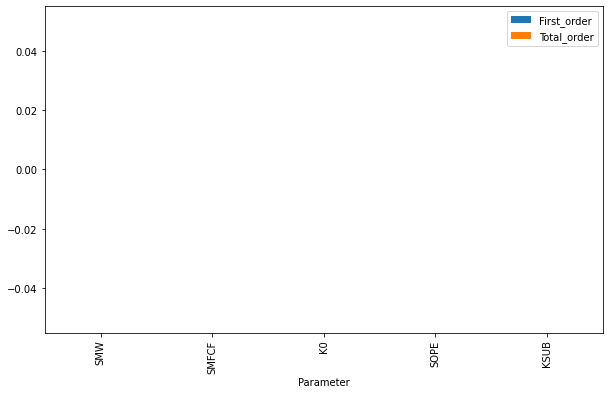

In [20]:
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
fig, axes = plt.subplots(figsize=(10,6))
df_sensitivity.plot(kind="bar", ax=axes)

## Second order sensitivities
Second order sensitivities deal with the combined sensitivity of two parameters. The results can therefore most easily be visualized through a matrix 

In [21]:
# Show second-order sensitivities
second_order = np.array(Si['S2'])
pd.DataFrame(second_order, index=problem["names"], columns=problem["names"])

,SMW,SMFCF,K0,SOPE,KSUB
SMW,NaN,NaN,NaN,NaN,NaN
SMFCF,NaN,NaN,NaN,NaN,NaN
K0,NaN,NaN,NaN,NaN,NaN
SOPE,NaN,NaN,NaN,NaN,NaN
KSUB,NaN,NaN,NaN,NaN,NaN


or through an image showing the values in the matrix values graphically. From the results, it is clear that the second order interactions are small as all indices have a value < 0.1.

In [ ]:
# Visualise second-order sensitivities
fig, axes = plt.subplots(figsize=(8,10))
aximage = axes.matshow(second_order, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
cbar = fig.colorbar(aximage)
aximage.axes.set_xticks(range(len(problem["names"])))
aximage.axes.set_xticklabels(problem["names"], rotation=45)
r = aximage.axes.set_yticklabels([""] + problem["names"])

In [ ]:
df_sensitivity.head(10)

## Explanation
The background of the sensitivity of sugarbeet yield to TSUM1 is related to the fact that a larger TSUM1 means that the crop will remain in its vegetative stage for a longer period. Given that there is a fixed harvest date this means that the time available for accumulating sugar in the beet root is shorter and thus simulated yields are lower.  Apparently, the other parameters that are part of the analysis do not have large impact within the selected ranges and thus TSUM1 dominates in terms of sensitivity over the other parameters.

## Scalar Crop Variables of Interest
- TSUM1 - Thermal time from emergence to anthesis 
- CVO - Conversion efficiency of assimilates into storage organ
- CVR - Conversion efficiency of assimilates into root 
- CVS - Conversion efficiency of assimilates into stem 

## Non-scalar Crop Variables of Interest
- SLATB - Specific leaf area as a function of development stage(hakg-1)
- AMAXTB - Maximum leaf CO2 assimilation rate as a function of development stage of the crop 
- KDIFTB - Extinction coefficient for diffuse visible light as function of development stage

In [ ]:
def generate_dist(param_name, mu, std, n_samples, target_variable):
    param_values = np.linspace(start=mu-std, stop=mu+std, num=n_samples)  #650 - temp. sum from emergence to init. beet growth [cel d]
    results = []
    for param in param_values:
        params.clear_override()
        params.set_override(param_name, param)
        wofost = Wofost71_PP(params, wdp, agro)
        wofost.run_till_terminate()
        r = wofost.get_summary_output()
        results.append(r[0][target_variable])

    df = pd.DataFrame({param_name: param_values,
                       target_variable: results}
                     ).set_index(param_name)
    
    return df

In [ ]:
mu = 650
std = mu*1.5
param_name = "TSUM1"
n_samples = 20
target_variable = "TWSO"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title="Impact of {} on sugar beet yield".format(param_name), figsize=(10,8))

In [ ]:
mu = 0.820
std = mu*1.5
param_name = "CVO"
n_samples = 20
target_variable = "TWSO"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title="Impact of {} on sugar beet yield".format(param_name), figsize=(10,8))

In [ ]:
mu = 0.720
std = mu*1.5
param_name = "CVR"
n_samples = 20
target_variable = "TWSO"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title="Impact of {} on sugar beet yield".format(param_name), figsize=(10,8))

In [ ]:
mu = 0.690
std = mu*1.5
param_name = "CVS"
n_samples = 20
target_variable = "TWSO"
df = generate_dist(param_name, mu, std, n_samples, target_variable)
r = df.plot(title="Impact of {} on sugar beet yield".format(param_name), figsize=(10,8))